# multiprocessing 多进程

参考资料：https://blog.csdn.net/brucewong0516/article/details/85776194

## Process 进程类

### 简介

#### Process的创建

```
 Process(group=None, target=None, name=None, args=(), kwargs={}, *, daemon=None)
```
Process方法用来创建进程类的示例，Process类使用方式与Threading类似，可以实现多进程的创建，启动，关闭等操作。  
一般需要传入target（目标函数），args（函数的参数）

#### Process类的属性和方法
1、run（）
       表示进程运行的方法。可以在子类中重写此方法。标准run() 方法调用传递给对象构造函数的可调用对象作为目标参数（如果有），分别使用args和kwargs参数中的顺序和关键字参数。

2、start（）
       进程准备就绪，等待CPU调度。

3、join（[timeout] ）
       如果可选参数timeout是None，则该方法将阻塞，直到join()调用其方法的进程终止。如果timeout是一个正数，它最多会阻塞timeout秒。请注意，None如果方法的进程终止或方法超时，则返回该方法。检查进程exitcode以确定它是否终止。

4、name
       进程的名称。该名称是一个字符串，仅用于识别目的。

5、is_alive（）
       返回进程是否存活。从start() 方法返回到子进程终止的那一刻，进程对象仍处于活动状态。

6、daemon
       进程的守护进程标志，一个布尔值。必须在start()调用之前设置，当进程退出时，它会尝试终止其所有被设为守护进程的子进程，即设为守护进程的子进程会随主线程的结束而结束。

7、pid
       返回进程ID。在产生该过程之前，这将是 None。

8、exitcode
       子进程的退出代码。None 如果流程尚未终止，这将是负值, -N表示孩子被信号N终止。

**需要注意的是start()，join()，is_alive()， terminate()和exitcode方法只能由创建进程对象的过程调用。**

### 示例
**注意：在jupyter notebook中，即使一个代码块执行完了，主进程依然没有结束，所以以下代码的守护进程运行结果不符合预期，要想看到守护进程的效果需要去创建py文件用python执行**

In [13]:
from multiprocessing import Process
import time
import os

def info(inf=None):
    print('-'*20)
    if inf: print(inf)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())
    print('-'*20+'\n')

def f(name):
    info('Child process')
    time.sleep(3)
    print('hello', name)

if __name__ == '__main__':
    print('主进程开始\n')
    info('Parent process')
    p = Process(target=f, args=('bob',))
    p.daemon = True
    print("p.daemon =", p.daemon)
    p.start()
#     p.join(1)
    print('name:', p.name)
    print('is_alive:', p.is_alive())
    print('exitcode:', p.exitcode)
    print('主进程退出\n')

主进程开始

--------------------
Parent process
module name: __main__
parent process: 4042
process id: 4459
--------------------

p.daemon = True
name: Process-15
is_alive: True
exitcode: None
主进程退出

--------------------
Child process
module name: __main__
parent process: 4459
process id: 10473
--------------------

hello bob


在上述逻辑中，子进程会休息3s然后再打印一句话才结束，同时设定join(1)阻塞1s，阻塞在1s后结束，因为我们并没有守护主进程，所以主进程结束后，子进程依然alive；  
如果想要守护主进程，设定p.daemon = True:


In [7]:
if __name__ == '__main__':
    info('Parent process')
    p = Process(target=f, args=('bob',))
    p.daemon = True
    print("daemon:", p.daemon)
    p.start()
    # p.join(1)
    print('name:', p.name)
    print('is_alive:', p.is_alive())
    print('exitcode:', p.exitcode)


--------------------
Parent process
module name: __main__
parent process: 4042
process id: 4459
--------------------

daemon: True
name: Process-9
is_alive: True
exitcode: None
--------------------
Child process
module name: __main__
parent process: 4459
process id: 10121
--------------------

hello bob


在上述逻辑中，子进程会休息3s然后再打印一句话才结束，我们的设定守护主进程，然后主进程结束后，打印的is_alive: True这句话其实是在主进程里运行的，所以此时子进程确实是alive，但是主进程结束后子进程也结束了，不会运行info() 函数

## Pool 进程池
### Pool类的定义  
```python
class multiprocessing.pool.Pool([processes[, initializer[, initargs[, maxtasksperchild[, context]]]]])
```
### 创建Pool类的实例：Pool方法
Pool方法(multiprocess.Pool)用来创建一个线程池类（multiprocess.pool.Pool）的实例，processes为可同时运行的进程数,默认值为os.cpu_count()，最大不超过os.cpu_count()

### Pool类的方法
四种实现并发的方法

|             | Multi-args | Concurrence | Blocking | Ordered-results |
| ----------- | ---------- | ----------- | -------- | --------------- |
| map         | no         | yes         | yes      | yes             |
| apply       | yes        | no          | yes      | no              |
| map_async   | no         | yes         | no       | yes             |
| apply_async | yes        | yes         | no       | no              |

map 和 map_async 入参为迭代器类型，可以批量调用。而apply和apply_async只能一个个调用。

In [6]:
import os
import time
import random
from multiprocess import Pool

def f(name):
#     start = time.time()
    print('task %s (%s) start...\n' % (name, os.getpid()))
    t = random.randint(1,6) * 0.5
    time.sleep(0.5)
#     end = time.time()
#     print('Task %s runs %0.2f seconds.\n' % (name, (end - start)))
    print('Task %s (%s) end\n' % (name, os.getpid()))
    return t

#### map（func，iterable [，chunksize ] ）
入参：迭代器类型，可批量调用  
同步：子进程和父进程之间的运行方式为同步

In [20]:
print('start')

with Pool() as p: # Pool类属于上下文管理器，可以用with as 自动分配和释放资源，并处理异常，若不用with，则需要手动close
    results = p.map(f,range(10))
    
print('父进程会等待子进程全部执行完才执行这一句')
print("results:", results)
print('end')

start
task 0 (12588) start...
task 2 (12592) start...
task 1 (12589) start...
task 3 (12590) start...


Task 2 (12592) end
Task 0 (12588) end



task 4 (12592) start...

Task 3 (12590) end

Task 4 (12592) end
Task 1 (12589) end
task 5 (12588) start...




Task 5 (12588) end
task 6 (12589) start...
task 7 (12590) start...


Task 6 (12589) end
Task 7 (12590) end


task 9 (12590) start...

Task 9 (12590) end

task 8 (12592) start...


Task 8 (12592) end

父进程会等待子进程全部执行完才执行这一句
result: [2.5, 1.5, 2.0, 2.5, 0.5, 1.5, 1.0, 0.5, 2.0, 1.0]
end


#### map_async（func，iterable [，chunksize [，callback [，error_callback ] ] ] ）
入参：迭代器类型，可批量调用  
异步：子进程和父进程之间的运行方式为异步

In [7]:
print('start')

results = []
with Pool() as p: # Pool类属于上下文管理器，可以用with as 自动分配和释放资源，并处理异常，若不用with，则需要手动close
    p.map_async(f,range(6), callback=lambda result: results.append(result), error_callback=lambda e: print(e))

print('父进程不会等待子进程，而是继续向下执行，除非遇到get或join')

# p.close()
p.join()
print("results:", results)
print('end')

start
父进程不会等待子进程，而是继续向下执行，除非遇到get或join
results: []
end


不知道为什么results为空，即使等待3秒

#### apply（func [，args [，kwds ] ] ）

In [30]:
print('start')

results = []
with Pool() as p: # Pool类属于上下文管理器，可以用with as 自动分配和释放资源，并处理异常，若不用with，则需要手动close
    for i in range(6):
        results.append(p.apply(f, (i,)))

print('父进程会等待子进程执行完才执行这一句')
print("results:", results)
print('end')

start
task 0 (13395) start...

Task 0 (13395) end

task 1 (13396) start...

Task 1 (13396) end

task 2 (13397) start...

Task 2 (13397) end

task 3 (13398) start...

Task 3 (13398) end

task 4 (13395) start...

Task 4 (13395) end

task 5 (13396) start...

Task 5 (13396) end

父进程会等待子进程执行完才执行这一句
results: [2.5, 2.5, 0.5, 1.0, 1.0, 2.5]
end


#### apply_async（func [，args [，kwds [，callback [，error_callback ] ] ] ] ）
返回值类型：multiprocess.pool.ApplyResult  
若调用ApplyResult的get方法，则主进程会等待该子进程结束，并获取返回值

In [ ]:
print('start')

results = []
with Pool() as p: # Pool类属于上下文管理器，可以用with as 自动分配和释放资源，并处理异常，若不用with，则需要手动close
    for i in range(6):
        
        results.append(p.apply_async(f, (i,)))

print('父进程不会等待子进程执行完才执行这一句')
results = [result.get() for result in results]
print("results:", results)
print('end')

#### 综合示例

In [4]:
import random
from multiprocess import Pool

pool = Pool(2)

def worker(name='', num=0):
    return f"{name}: {random.random()+num}"

# map
results = pool.map(worker, ["map1","map2","map3"])

# apply
for x, y in [["apply1", 1], ["apply2", 2]]:
    results.append(pool.apply(worker, (x, y)))

def collect_result(result):
    results.append(result)

# map_async
pool.map_async(worker, ["map_async1","map_async2","map_async3"], callback=collect_result)

# apply_async
for x, y in [["apply_async1", 1], ["apply_async2", 2]]:
    pool.apply_async(worker, (x, y), callback=collect_result)
    
pool.close()
pool.join()

print('\n'.join([str(i) for i in results]))

map1: 0.6431123587353627
map2: 0.4834283782311871
map3: 0.6391021467659649
apply1: 1.2966714396835157
apply2: 2.7892942116956077
apply_async1: 1.7203026065434737
apply_async2: 2.6153693817539683
['map_async1: 0.033018377194001136', 'map_async2: 0.5901408106371339', 'map_async3: 0.33463786924357386']


## Queue、Pipe 进程间通信

### Queue的创建
```
queue = Queue(maxsize=0)
```
### Queue类的两个方法
#### put() 放数据
```
put(obj, block=True, timeout=None)
```
block：是否阻塞  
timeout：等待时间

当block=True时，写入是阻塞式的，阻塞时间由timeout确定。  
当队列queue被（其他线程）写满后，这段代码就会阻塞，直至其他线程取走数据。Queue.put（）方法加上 block=False 的参数，即可解决这个隐蔽的问题。  
注意，若以非阻塞方式写队列，当队列满时会抛出 exception Queue.Full 的异常
#### get() 取数据
```
get(block=True, timeout=None)
```
block：是否阻塞  
timeout：等待时间


### Queue使用示例

In [2]:
from multiprocessing import Process, Queue
import os, time, random

# 写数据进程执行的代码:
def write(q,urls):
    print('Process(%s) is writing...' % os.getpid())
    for url in urls:
        q.put(url)
        print('Put %s to queue...' % url)
        time.sleep(random.random())
        
# 读数据进程执行的代码:
def read(q):
    print('Process(%s) is reading...' % os.getpid())
    while True:
        url = q.get(True)
        print('Get %s from queue.' % url)
        
        
if __name__=='__main__':
    # 父进程创建Queue，并传给各个子进程：
    q = Queue()
    writer1 = Process(target=write, args=(q,['url_1', 'url_2', 'url_3']))
    writer2 = Process(target=write, args=(q,['url_4','url_5','url_6']))
    reader = Process(target=read, args=(q,))
    
    # 启动子进程writer，写入:
    writer1.start()
    writer2.start()
    
    # 启动子进程reader，读取:
    reader.start()
    
    # 等待writer结束:
    writer1.join()
    writer2.join()
    
    # reader进程里是死循环，无法等待其结束，只能强行终止:
    reader.terminate()

Process(6487) is writing...
Process(6490) is writing...
Process(6493) is reading...Put url_1 to queue...

Put url_4 to queue...Get url_1 from queue.

Get url_4 from queue.
Put url_5 to queue...Get url_5 from queue.

Put url_6 to queue...Get url_6 from queue.

Put url_2 to queue...Get url_2 from queue.

Put url_3 to queue...Get url_3 from queue.



### Pipe的使用
Pipe()方法用于创建管道的两端，类型为```multiprocessing.connection.Connection```
```
connection1, connection2 = Pipe(duplex=True)
```

### Connection类的方法
#### send() 发数据
```
send(obj)：  Send a (picklable) object
```
#### recv() 收数据
```
recv()：  Receive a (picklable) object
```
#### send_bytes() 发比特数据
```
send_bytes(buf, offset=0, size=None)：  Send the bytes data from a bytes-like object
```
#### recv_bytes() 收比特数据
```
recv_bytes(maxlength=None)：    Receive bytes data as a bytes object.
```
#### close() 关闭连接

### Pipe使用示例
管道是可以同时发送和接受消息的

In [24]:
from multiprocessing import Process, Pipe

def talk(pipe):
    pipe.send(dict(name='Bob', spam=42))            # 传输一个字典
    reply = pipe.recv()                             # 接收传输的数据
    print('talker got:', reply)

if __name__ == '__main__':
    (parentEnd, childEnd) = Pipe()                  # 创建两个 Pipe() 实例，也可以改成 conf1， conf2
    child = Process(target=talk, args=(childEnd,))  # 创建一个 Process 进程，名称为 child
    child.start()                                   # 启动进程
    print('parent got:', parentEnd.recv())          # parentEnd 是一个 Pip() 管道，可以接收 child Process 进程传输的数据
    parentEnd.send({x * 2 for x in 'spam'})         # parentEnd 是一个 Pip() 管道，可以使用 send 方法来传输数据
    child.join()                                    # 传输的数据被 talk 函数内的 pip 管道接收，并赋值给 reply
    print('parent exit')

talker got: {'aa', 'ss', 'pp', 'mm'}
parent got: {'name': 'Bob', 'spam': 42}
parent exit


## Value 进程之间的共享变量
### 创建Value
```
Value(typecode_or_type, *args, lock=True)
```
返回值：
    该方法返回从共享内存中分配的一个ctypes对象  
参数：  
    typecode_or_type： 定义了返回的类型。它要么是一个ctypes类型，要么是一个代表ctypes类型的code  
    *args：传递给ctypes的构造参数
    
拓展：
ctypes是Python的一个外部函数库，它提供了和C语言兼容的数据类型，可以调用DLLs或者共享库的函数，能被用作在python中包裹这些库。  
typecode 查阅下表：  

| Type Code | C Type         | Python Type       |
| --------- | -------------- | ----------------- |
| "c"       | char           | character         |
| "b"       | signed char    | int               |
| "B"       | unsigned char  | int               |
| "u"       | Py_UNICODE     | unicode character |
| "h"       | signed short   | int               |
| "H"       | unsigned short | int               |
| "i"       | signed int     | int               |
| "I"       | unsigned int   | int               |
| "l"       | signed long    | int               |
| "L"       | unsigned long  | int               |
| "f"       | float          | float             |
| "d"       | double         | float             |

如果共享的是字符串，则在上表是找不到映射关系的，所以没有typecode可用。所以我们需要使用原始的ctype类型
```
from ctypes import c_char_p
ss = Value(c_char_p, 'ss')
```
ctype类型查阅下表：  
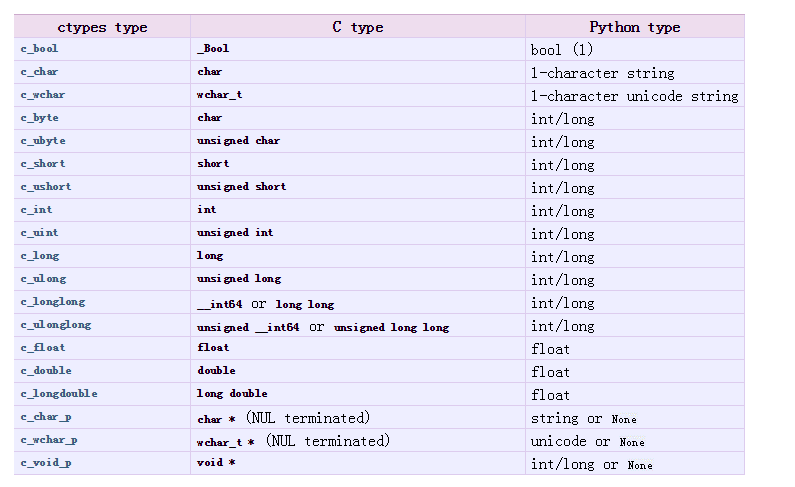

### Value使用示例

In [2]:
import time 
from multiprocessing import Process, Value
from ctypes import c_int

def target(v, num):
    for _ in range(5):
        time.sleep(0.1)
        v.value += num
        print(v.value, end=', ')
        
# v = Value('i',0)  # 用typecode创建Value
v = Value(c_int,0)  # 用ctype创建Value
p1 = Process(target=target, args=(v,1))
p2 = Process(target=target, args=(v,2))

p1.start()
p2.start()
p1.join()
p2.join()

## Lock、Rlock 进程同步
* 创建锁  
```
lock = Lock()
```

* 加锁  
```
lock.acquire()
```

* 释放锁  
```
lock.release()
```

In [32]:
import time 
from multiprocessing import Process, Value, Lock, RLock

def target(v, num, lock):
    lock.acquire() # 加锁后其他进程不可更改该共享变量
    for _ in range(5):
        time.sleep(0.1)
        v.value += num
        print(v.value, end=' ')
    lock.release() # 释放锁

# lock = Lock()
lock1 = RLock()
lock2 = RLock()
v1 = Value('i',0)
v2 = Value('i',100)

ps = []
ps.append(Process(target=target, args=(v1,1,lock)))
ps.append(Process(target=target, args=(v1,2,lock)))
ps.append(Process(target=target, args=(v2,1,lock)))
ps.append(Process(target=target, args=(v2,2,lock2)))

for p in ps:
    p.start()
    p.join()


1 2 3 4 5 7 9 11 13 15 101 102 103 104 105 107 109 111 113 115 

## 总结

# multiprocessing.dummy 多线程
## multiprocessing.dummy.Pool 创建线程池
```
pool = Pool(processes=None, initializer=None, initargs=())
type(pool)
<class 'multiprocessing.pool.ThreadPool'>
```


Multiprocessing.dummy.Pool() 与Multiprocessing.Pool() 的用法一样

    非阻塞方法
    multiprocessing.dummy.Pool.apply_async() 和 multiprocessing.dummy.Pool.map_async()
    线程并发执行
    
    阻塞方法
    multiprocessing.dummy.Pool.apply()和 multiprocessing.dummy.Pool.map()
    线程顺序执行

# threading 多线程
## 线程的生命周期
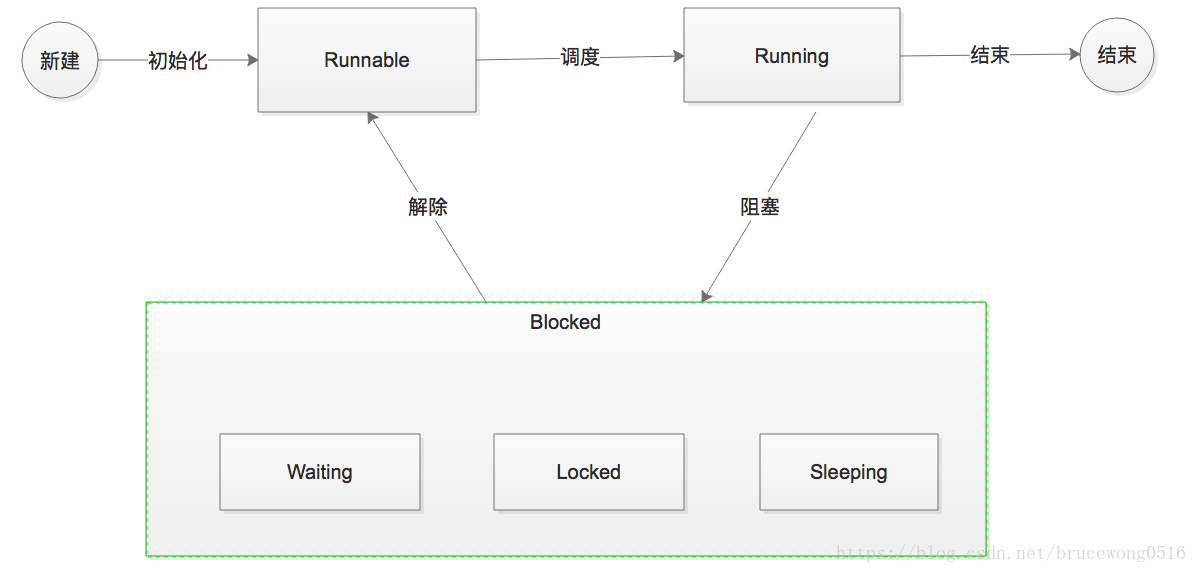
    1. 新建:使用线程的第一步就是创建线程,创建后的线程只是进入可执行的状态,也就是Runnable
    2. Runnable:进入此状态的线程还并未开始运行,一旦CPU分配时间片给这个线程后,该线程才正式的开始运行
    3. Running:线程正式开始运行,在运行过程中线程可能会进入阻塞的状态,即Blocked
    4. Blocked:在该状态下,线程暂停运行,解除阻塞后,线程会进入Runnable状态,等待CPU再次分配时间片给它
    5. 结束:线程方法执行完毕或者因为异常终止返回

其中最复杂的是线程从Running进入Blocked状态,通常有三种情况:  
    睡眠:线程主动调用 **sleep()** 或 **join()** 方法后.  
    等待:线程中调用 **wait()** 方法,此时需要有其他线程通过 **notify()** 方法来唤醒  
    同步:线程中获取线程锁,但是因为资源已经被其他线程占用时.

## 常用方法

### 创建线程  Thread(...)  
原型：
```
Thread(group=None, target=None, name=None, args=(), kwargs=None, *, daemon=None)
```
举例：
```
thread = Thread(target=target,args = [])  
```
    
### 设置线程为守护线程  Thread.setDaemon(True)  
    Thread.setDaemon(True)  
    
### 启动线程  Thread.start()
    Thread.start()
    
### 创建锁  Lock() & RLock()
#### Lock 和 RLock 对比
|       | 是否同一线程 | 是否可重复加锁 |
| ----- | ------------ | -------------- |
| Lock  | 否           | 否             |
| RLock | 是           | 是             |

#### Lock
Lock锁是Python的原始锁，在锁定时不属于任何一个线程。在调用了 lock.acquire() 方法后，进入锁定状态，lock.release()方法可以解锁。底层是通过一个函数来实现的，会根据不同的操作系统选择一个最有效的版本实例
```
    lock = Lock()
```

#### RLock
RLock锁是一个可以被同一个线程多次 acquire 的锁，但是最后必须由获取它的线程来释放它，不论同一个线程调用了多少次的acquire，最后它都必须调用相同次数的 release 才能完全释放锁，这个时候其他的线程才能获取这个锁。RLock内部的锁的实现和Lock用的是同一个函数
```
    rlock = RLock()
```
    
### 加锁  lock.acquire() 
    lock.acquire()  
    调用acquire([timeout])时，线程将一直阻塞，直到获得锁定或者直到timeout秒后（timeout参数可选）。  
    返回是否获得锁。

### 释放锁  lock.release()
    lock.release()

## 示例

In [22]:
import threading
import time

#定义线程需要做的内容，写在函数里面
def target():
    print('线程 %s 正在运行' % threading.current_thread().name)
    time.sleep(5)
    print('线程 %s 结束' % threading.current_thread().name)

print('线程 %s 正在运行' % threading.current_thread().name)

# 创建线程
thread = threading.Thread(target=target,args = [])
# 设置该线程为守护线程 （即设置子线程随主线程的结束而结束：）
thread.setDaemon(True)
# 启动线程
thread.start()
# 阻塞主线程，使主线程等待该子线程结束方才继续运行，若传递参数timeout，则等待timeout秒
# thread.join(2)

print('线程 %s 结束' % threading.current_thread().name) #在jupyter中，此时主线程其实还没结束，所以看不到守护的效果

线程 MainThread 正在运行
线程 Thread-11 正在运行
线程 MainThread 结束
线程 Thread-11 结束


In [36]:
import threading
import time

num = 0

lock = threading.RLock()


# 调用acquire([timeout])时，线程将一直阻塞，
# 直到获得锁定或者直到timeout秒后（timeout参数可选）。
# 返回是否获得锁。
def Func():
    lock.acquire()
    
    time.sleep(0.3)
    global num
    num += 1
    print(num)
    
    lock.release()


for i in range(10):
    t = threading.Thread(target=Func)
    t.start()

1
2
3
4
5
6
7
8
9
10
